<a href="https://colab.research.google.com/github/ramon-m-machado/Markdown-Tutorial/blob/master/VGGsNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of microorganisms into 10 classes using **VGG16** and **VGG19**


# Environment Setup

## Drive


In [1]:
# # get the images from the Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

## Imports

In [2]:
# basic imports
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
# plot imports
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.graph_objects as go

In [4]:
# read and process images
import imageio.v2 as iio
from PIL import Image
import cv2 as cv

In [5]:
# access files in colab's folders
import os

In [6]:
# regex to get the class name from the file name
import re

In [7]:
# some randomness functions
import random

In [8]:
# k-fold (cross validation)
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
# like top_k_categorical_accuracy but for labels integer-encoded
from tensorflow.keras.metrics import sparse_top_k_categorical_accuracy
from sklearn.metrics import f1_score

In [9]:
# imports data augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img

In [10]:
# confusion matrix
from plotly.subplots import make_subplots
from matplotlib.colors import LinearSegmentedColormap

In [11]:
# imports from evaluation metrics
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score

## GPU

In [12]:
# checking the use of colab's GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Control constants

Path info

In [13]:
# define values related to Colab's environment path
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/FAPESP/images/'
# BASE_PATH = '/content/drive/MyDrive/micro_data/'
FOLDERS = ['Control', 'Serial', 'Streak']  # images will be read from these 3 folders in the base path

Learning info

In [14]:
# define values related to learning, such as image size and number of classes
SIZE = 224  # (size, size)
BORDER = 150  # this will be cutted from the original image, because the microorganism are in the center
INPUT_SHAPE = (224, 224, 3)

NUM_SPLITS = 5  # k value for k-fold cross-validation

NUMBER_OF_CLASSES = 10

BATCH_SIZE_TRAIN = 40
BATCH_SIZE_TEST = 40

CLASSES = ["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10"]

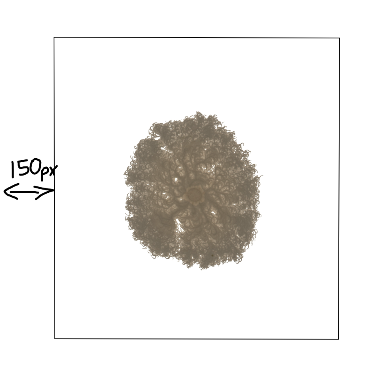

Randomness info

In [15]:
# define a random seed, allowing determinism at experiments
RANDOM_SEED = 8475

tf.keras.utils.set_random_seed(RANDOM_SEED)
tf.config.experimental.enable_op_determinism()

# Loading and preprocessing images

## Read images and construct Dataset

Defining functions to read and preprocess images

In [16]:
def preprocessImg(path, size, border):
  # read the images in folder
  img = np.array(Image.open(path)) #.convert('L')) # uncoment to gray scale images

  # standardizating values (interval [0, 1])
  imgStandard = img / 255

  # cut the border of the image
  imgCutted = imgStandard[border:-border,border:-border]

  # resize the original image
  imgResized = cv.resize(imgCutted, dsize = (size, size))

  return imgResized

In [17]:
def getClassWithRegex(file):
  regex_result = re.search(r"\d-\d*_.M_P1C(\d+)", file)
  imgClass = int(regex_result.groups()[0])-1

  y = np.zeros(NUMBER_OF_CLASSES)
  y[imgClass] = 1

  return y

In [18]:
def readDataImagesFromDrive(files, size, border):
  for file in files:
    img = preprocessImg(file, size, border)
    _, filename = os.path.split(file)
    imgClass = getClassWithRegex(filename)

    yield img, imgClass

In [19]:
def dataset_factory(files, classes, size=400, border=0, num_classes=5, batch_size = 32, split=1):
  """
  Returns a tf.data.Dataset based on specified params

  # Params

  ## Files: iterable of strings

  List containing the full path of the images

  ## size: integer

  Images loaded will be resized to (size, size)

  ## border: integer

  Number of pixels cropped off from each side of the images. The cropp is made at the original image size.

  ## num_classes: integer

  Number of classes on the image dataset

  ## batch_size: integer

  Number of images at each batch

  ## split: integer or float

  Determines the split method for the dataset.
  integer -> number of splits k for k-fold cross-validation
  float -> split ratio for holdout-validation. The specified value is the % of data in the train dataset.

  # Return

  ## dataset: tf.data.Dataset

  Returns a tf.data.Dataset based on specified params.
  k-fold cross-validation -> a list of tuples of datasets (train, test)
  holdout-validation -> a tuple of datasets (train, test)
  """

  if type(split) is float:
    separator_index = int(len(files)*split)

    random.shuffle(files)

    train_files = files[:separator_index]
    test_files = files[separator_index:]

    train_dataset = tf.data.Dataset.from_generator(
          lambda : readDataImagesFromDrive(train_files, size, border),
          output_signature=(
              tf.TensorSpec(shape=(size, size, 3), dtype=tf.float32),
              tf.TensorSpec(shape=(num_classes), dtype=tf.int8)
          )
      ).batch(batch_size)

    test_dataset = tf.data.Dataset.from_generator(
        lambda : readDataImagesFromDrive(test_files, size, border),
        output_signature=(
            tf.TensorSpec(shape=(size, size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(num_classes), dtype=tf.int8)
        )
    ).batch(batch_size)

    return (train_dataset, test_dataset)

  else:
    skf = StratifiedKFold(n_splits=split)

    random.shuffle(files)

    folds = []
    for train_index, test_index in skf.split(files, classes):

      train_files = [files[i] for i in train_index]
      test_files = [files[i] for i in test_index]

      train_dataset = tf.data.Dataset.from_generator(
          lambda : readDataImagesFromDrive(train_files, size, border),
          output_signature=(
              tf.TensorSpec(shape=(size, size, 3), dtype=tf.float32),
              tf.TensorSpec(shape=(num_classes), dtype=tf.int8)
          )
      ).batch(batch_size)

      test_dataset = tf.data.Dataset.from_generator(
          lambda : readDataImagesFromDrive(test_files, size, border),
          output_signature=(
              tf.TensorSpec(shape=(size, size, 3), dtype=tf.float32),
              tf.TensorSpec(shape=(num_classes), dtype=tf.int8)
          )
      ).batch(batch_size)

      folds.append((train_dataset, test_dataset))

    return folds

In [20]:
# getting images name and location
files = []
classes = []
for i in range(len(FOLDERS)):
  curr_folder = os.path.join(BASE_PATH, FOLDERS[i])
  for file in os.listdir(curr_folder):
    curr_file = os.path.join(curr_folder, file)
    files.append(curr_file)
    classes.append(list(getClassWithRegex(file)))
classes = np.argmax(np.array(classes, dtype=np.uint8), axis=1)

In [21]:
# constructing the image dataset
folds = dataset_factory(
    files,
    classes,
    size = SIZE,
    border = BORDER,
    num_classes = NUMBER_OF_CLASSES,
    batch_size = BATCH_SIZE_TRAIN,
    split = NUM_SPLITS
)

Images examples

In [22]:
# creating a data iterator to access the actual data
train_dataset, test_dataset = folds[0]
iterator = train_dataset.as_numpy_iterator()

In [23]:
# getting the first batch of data
batch = iterator.next()
images = batch[0]
labels = batch[1]

/content/drive/MyDrive/Colab Notebooks/FAPESP/images/Serial/7-10_AM_P1C10_Serial.jpg
[0 0 0 0 0 0 0 0 0 1]


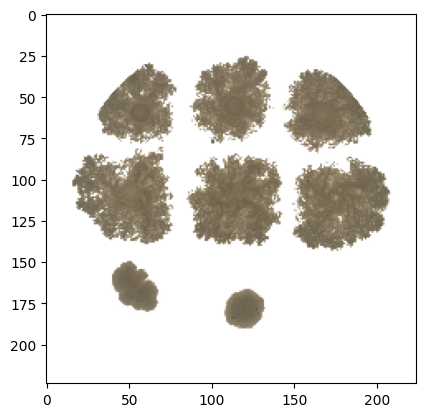

In [24]:
print(files[0])
print(labels[0])
plt.imshow(images[0])

/content/drive/MyDrive/Colab Notebooks/FAPESP/images/Streak/7-10_AM_P1C1_Streak.jpg
[1 0 0 0 0 0 0 0 0 0]


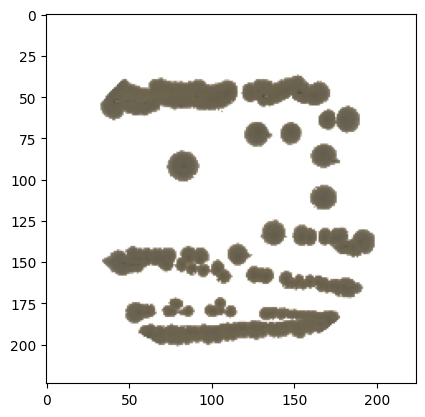

In [25]:
print(files[15])
print(labels[15])
plt.imshow(images[15])

# Training

## VGGs

In [26]:
from keras.models import Model
from keras import optimizers
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

In [39]:
def initialize_VGG(is_vgg19=False):

    input_shape = (224, 224, 3)

    base_model = VGG19 if is_vgg19 else VGG16

    vgg = base_model(input_shape=input_shape, weights='imagenet', include_top=False)

    # Freezing blocks from 1 to 5
    for layer in vgg.layers:
        layer.trainable = False

    flatten = Flatten()(vgg.output)

    dense1 = Dense(256, activation='relu')(flatten)
    prediction = Dense(NUMBER_OF_CLASSES, activation='sigmoid')(dense1)

    model = Model(inputs=vgg.input, outputs=prediction)

    return model

**VGG16**

In [40]:
test_vgg = initialize_VGG(is_vgg19 = False)
test_vgg.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

**VGG19**

In [29]:
test_vgg = initialize_VGG(is_vgg19 = True)
test_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Metrics

top 2, 3 and 5k

Example with top 3k:

if the correct class is among the 3 most likely predictions, it counts as a hit towards the top3k

In [30]:
def top_2k_accuracy(y_true,y_pred):
  return sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3k_accuracy(y_true,y_pred):
  return sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_5k_accuracy(y_true,y_pred):
  return sparse_top_k_categorical_accuracy(y_true, y_pred, k=5)

def true_positive(y_true, y_pred):
  return tf.reduce_sum(tf.cast(tf.math.equal(y_true, y_pred), dtype=tf.float32), axis=0)


In [31]:
evaluation_metrics = ['accuracy',
           tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="top_2k", dtype=None),
           tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top_3k", dtype=None),
           tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top_5k", dtype=None)]

## Callbacks

Callbacks to save model weights for each fold

In [32]:
cp_filename = lambda vgg, k : f'cp_vgg{vgg}_fold{k}.ckpt'

In [33]:
# Create a callback that saves the model's weights
create_checkpoint_callbacks = lambda num_checkpoints, checkpoint_path, vgg: [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path + cp_filename(vgg, k),
        save_weights_only=True,
        verbose=1
    ) for k in range(1, num_checkpoints+1)
]

In [34]:
CHECKPOINT_PATH_VGG16 = "/content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/"
CHECKPOINT_PATH_VGG19 = "/content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg19/"
CHECKPOINT_DIR_VGG16 = os.path.dirname(CHECKPOINT_PATH_VGG16)
CHECKPOINT_DIR_VGG19 = os.path.dirname(CHECKPOINT_PATH_VGG19)
NUM_CHECKPOINTS = 5

In [35]:
cp_callback_vgg16 = create_checkpoint_callbacks(NUM_CHECKPOINTS, CHECKPOINT_PATH_VGG16, 16)
cp_callback_vgg19 = create_checkpoint_callbacks(NUM_CHECKPOINTS, CHECKPOINT_PATH_VGG19, 19)

Callback for early stop when loss stop decreasing

In [36]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

## K fold Cross-validation

In [41]:
def train_fine_tuning_VGG(train_dataset, test_dataset, cp_callback, evaluation_metrics, epochs, is_vgg19=False):

    vgg = initialize_VGG(is_vgg19)

    # Compile using LR = 2 × 10−5
    vgg.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate=2e-5),
                metrics=evaluation_metrics)

    # Training
    vgg.fit(
        train_dataset,
        epochs = epochs,
        callbacks=[earlyStopping, cp_callback],
        verbose = False
    )

    # Unfreezing from 3 to 5
    for i in range(3, len(vgg.layers)):
        vgg.layers[i].trainable = True

    # Compile again using LR = 1 × 10−5
    vgg.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate=1e-5),
                metrics=evaluation_metrics)

    # Training again
    vgg.fit(
        train_dataset,
        epochs = epochs,
        callbacks=[earlyStopping, cp_callback],
        verbose = False
    )

    y_pred = vgg.predict(test_dataset)

    return vgg, y_pred

Training and evaluating **VGG16**

In [42]:
EPOCHS = 2

# Save the predictions of every split
y_pred = []
y_true = []

# Create dictionaries to store metrics for each split
metrics = {
    'loss': np.empty(shape=(NUM_SPLITS)),
    'accuracy': np.empty(shape=(NUM_SPLITS)),
    'top_2': np.empty(shape=(NUM_SPLITS)),
    'top_3': np.empty(shape=(NUM_SPLITS)),
    'top_5': np.empty(shape=(NUM_SPLITS))
}

k = 0
for count, (train_dataset, test_dataset) in enumerate(folds):
    print(f'\nk: {k+1}/{NUM_SPLITS}\n')

    # Train the neural network and get predictions using VGG16
    vgg, y_pred_fold = train_fine_tuning_VGG(train_dataset, test_dataset, cp_callback_vgg16[k], evaluation_metrics, EPOCHS, is_vgg19=False)

    y_pred.append(y_pred_fold)

    # Evaluate the model and store metrics
    metrics['loss'][k], metrics['accuracy'][k], metrics['top_2'][k], metrics['top_3'][k], metrics['top_5'][k] = vgg.evaluate(test_dataset)

    k += 1


k: 1/5


Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold1.ckpt

Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold1.ckpt

Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold1.ckpt

Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold1.ckpt
1/1 [==============================] - 2s 2s/step - loss: 1.4214 - accuracy: 0.6000 - top_2k: 0.6500 - top_3k: 0.6750 - top_5k: 0.8250

k: 2/5


Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold2.ckpt

Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold2.ckpt

Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold2.ckpt

Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/FAPESP/models/vgg16/cp_vgg16_fold2.ckpt
1/1 [==

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step - loss: 1.4891 - accuracy: 0.6500 - top_2k: 0.7000 - top_3k: 0.7000 - top_5k: 0.7750


Example of getting saved weights

In [43]:
model = initialize_VGG(is_vgg19 = False);
model.load_weights(CHECKPOINT_PATH_VGG16 + cp_filename(16, 1));

## Evaluation metrics

Print evaluation metrics

In [44]:
for metric_name, metric_values in metrics.items():
    print(f'{metric_name.capitalize()}: {np.round(np.mean(metric_values), 4)}')

Loss: 1.4538
Accuracy: 0.615
Top_2: 0.67
Top_3: 0.69
Top_5: 0.795


Getting **y_true**

<h1> OBS.: Algum problema na divisao ainda, pq y true esta igual para todos os folds</h1>

In [45]:
y_true = []
for _, (_, test_dataset) in enumerate(folds):
  # use iterator to get the true class
  iterator = test_dataset.as_numpy_iterator()
  batch = iterator.next()
  y_true.append(np.argmax(batch[1], axis = 1))

In [46]:
classes

array([0, 3, 3, 8, 5, 2, 8, 9, 7, 7, 8, 2, 0, 2, 6, 6, 6, 0, 2, 7, 5, 7,
       5, 4, 3, 5, 3, 1, 0, 1, 8, 6, 4, 1, 9, 4, 4, 9, 1, 9, 3, 5, 6, 4,
       9, 1, 9, 3, 7, 8, 9, 2, 1, 5, 3, 6, 8, 8, 8, 2, 5, 2, 0, 9, 3, 5,
       4, 0, 7, 8, 7, 3, 9, 4, 6, 1, 1, 7, 7, 5, 6, 4, 1, 2, 0, 6, 0, 0,
       2, 4, 0, 1, 2, 7, 5, 4, 3, 8, 6, 9, 0, 1, 2, 3, 5, 8, 4, 6, 7, 9,
       0, 1, 2, 3, 4, 5, 6, 8, 7, 9, 0, 1, 2, 3, 5, 7, 6, 4, 9, 8, 0, 1,
       5, 3, 8, 7, 6, 4, 2, 9, 0, 1, 3, 2, 4, 6, 5, 7, 8, 9, 0, 1, 2, 3,
       5, 4, 6, 7, 8, 9, 0, 1, 2, 4, 6, 5, 3, 7, 8, 9, 0, 1, 3, 4, 2, 7,
       5, 8, 6, 9, 0, 1, 3, 5, 2, 4, 7, 6, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
       8, 9])

Turning both **y_true** and **y_pred** values into flatten


In [47]:
y_true

[array([3, 0, 5, 0, 2, 0, 4, 5, 6, 2, 6, 0, 1, 4, 7, 1, 8, 3, 9, 2, 9, 8,
        5, 2, 8, 9, 1, 6, 6, 8, 2, 7, 7, 2, 3, 6, 0, 2, 6, 1]),
 array([3, 0, 5, 0, 2, 0, 4, 5, 6, 2, 6, 0, 1, 4, 7, 1, 8, 3, 9, 2, 9, 8,
        5, 2, 8, 9, 1, 6, 6, 8, 2, 7, 7, 2, 3, 6, 0, 2, 6, 1]),
 array([3, 0, 5, 0, 2, 0, 4, 5, 6, 2, 6, 0, 1, 4, 7, 1, 8, 3, 9, 2, 9, 8,
        5, 2, 8, 9, 1, 6, 6, 8, 2, 7, 7, 2, 3, 6, 0, 2, 6, 1]),
 array([3, 0, 5, 0, 2, 0, 4, 5, 6, 2, 6, 0, 1, 4, 7, 1, 8, 3, 9, 2, 9, 8,
        5, 2, 8, 9, 1, 6, 6, 8, 2, 7, 7, 2, 3, 6, 0, 2, 6, 1]),
 array([3, 0, 5, 0, 2, 0, 4, 5, 6, 2, 6, 0, 1, 4, 7, 1, 8, 3, 9, 2, 9, 8,
        5, 2, 8, 9, 1, 6, 6, 8, 2, 7, 7, 2, 3, 6, 0, 2, 6, 1])]

In [48]:
y_true_flatten = np.array(y_true).flatten()
y_pred_flatten = np.argmax(y_pred, axis=2).flatten()

y_true_flatten[:10], y_pred_flatten[:10]

(array([3, 0, 5, 0, 2, 0, 4, 5, 6, 2]), array([3, 0, 5, 0, 1, 8, 8, 8, 8, 8]))

In [63]:
y_pred_flatten

array([3, 0, 5, 0, 1, 8, 8, 8, 8, 8, 6, 1, 1, 8, 1, 1, 8, 3, 9, 1, 9, 8,
       5, 2, 8, 9, 8, 6, 6, 8, 8, 7, 8, 2, 4, 6, 8, 8, 6, 1, 3, 0, 5, 0,
       1, 8, 5, 8, 8, 5, 6, 1, 1, 1, 1, 1, 5, 3, 9, 1, 9, 8, 5, 2, 8, 9,
       1, 6, 6, 8, 8, 7, 1, 2, 3, 6, 1, 1, 6, 1, 3, 0, 5, 0, 1, 1, 0, 1,
       1, 5, 6, 3, 1, 5, 3, 1, 8, 3, 9, 1, 9, 8, 5, 2, 8, 9, 5, 6, 6, 8,
       8, 4, 5, 2, 3, 6, 5, 1, 6, 1, 3, 0, 5, 0, 1, 1, 5, 8, 1, 8, 6, 1,
       1, 1, 5, 1, 8, 3, 9, 1, 9, 8, 5, 2, 1, 9, 1, 6, 7, 8, 8, 7, 5, 2,
       3, 6, 5, 8, 6, 1, 3, 0, 5, 0, 1, 0, 5, 5, 8, 8, 6, 1, 1, 1, 3, 1,
       8, 3, 9, 1, 9, 8, 5, 2, 8, 9, 1, 6, 6, 8, 8, 7, 1, 2, 3, 4, 1, 0,
       4, 1])

In [62]:
np.unique(classes, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20]))

In [50]:
from sklearn.metrics import accuracy_score

Check Accuracy

In [64]:
accuracy_score(y_true_flatten, y_pred_flatten)

0.615

Classification report

In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_true_flatten, y_pred_flatten))

              precision    recall  f1-score   support

           0       0.85      0.44      0.58        25
           1       0.37      0.90      0.52        20
           2       1.00      0.29      0.44        35
           3       0.82      0.93      0.87        15
           4       0.00      0.00      0.00        10
           5       0.46      0.73      0.56        15
           6       1.00      0.73      0.85        30
           7       0.80      0.27      0.40        15
           8       0.44      0.90      0.59        20
           9       1.00      1.00      1.00        15

    accuracy                           0.61       200
   macro avg       0.67      0.62      0.58       200
weighted avg       0.74      0.61      0.60       200



## Images missclassified

In [53]:
indexes_miss = np.where(y_pred_flatten != y_true_flatten)[0]
indexes_miss

array([  4,   5,   6,   7,   8,   9,  11,  13,  14,  19,  26,  30,  32,
        34,  36,  37,  44,  45,  46,  47,  48,  49,  51,  53,  54,  56,
        59,  70,  72,  76,  77,  84,  85,  86,  87,  88,  89,  91,  93,
        94,  99, 106, 110, 111, 112, 116, 117, 124, 125, 126, 127, 128,
       129, 131, 133, 134, 139, 144, 148, 150, 152, 156, 157, 164, 166,
       168, 169, 171, 173, 174, 179, 190, 192, 195, 196, 197, 198])

In [54]:
filenames_miss = np.asarray(files)[list(indexes_miss)]

Make a dataset of images missclassifieds

In [55]:
# make a dataset with batch_size = number of missclassified images
miss_dataset = tf.data.Dataset.from_generator(
          lambda : readDataImagesFromDrive(filenames_miss, SIZE, BORDER),
          output_signature=(
              tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32),
              tf.TensorSpec(shape=(NUMBER_OF_CLASSES), dtype=tf.int8)
          )
      ).batch(len(indexes_miss))

In [56]:
# use iterator in this dataset
iterator = miss_dataset.as_numpy_iterator()

In [57]:
# getting all the data from the unique batch
batch = iterator.next()

images = batch[0]
labels = batch[1]

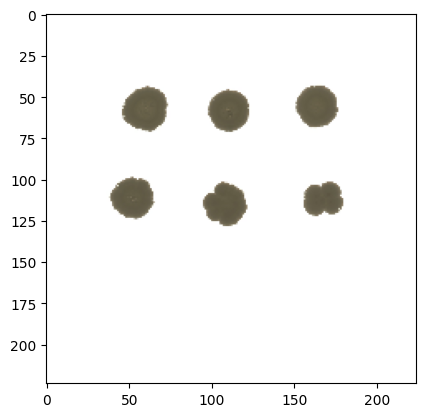

In [58]:
plt.imshow(images[0])

In [59]:
cf_matrix = tf.math.confusion_matrix(
          y_true_flatten,
          y_pred_flatten,
          num_classes=10,
          dtype=float,
          name="Confusion Matrix"
        )

In [60]:
colors_error = ["#94D2BD","#E9D8A6","#EE9B00","#CA6702","#BB3E03","#AE2012","#9B2226","#005F73"]
cmap_error = LinearSegmentedColormap.from_list("", colors_error)

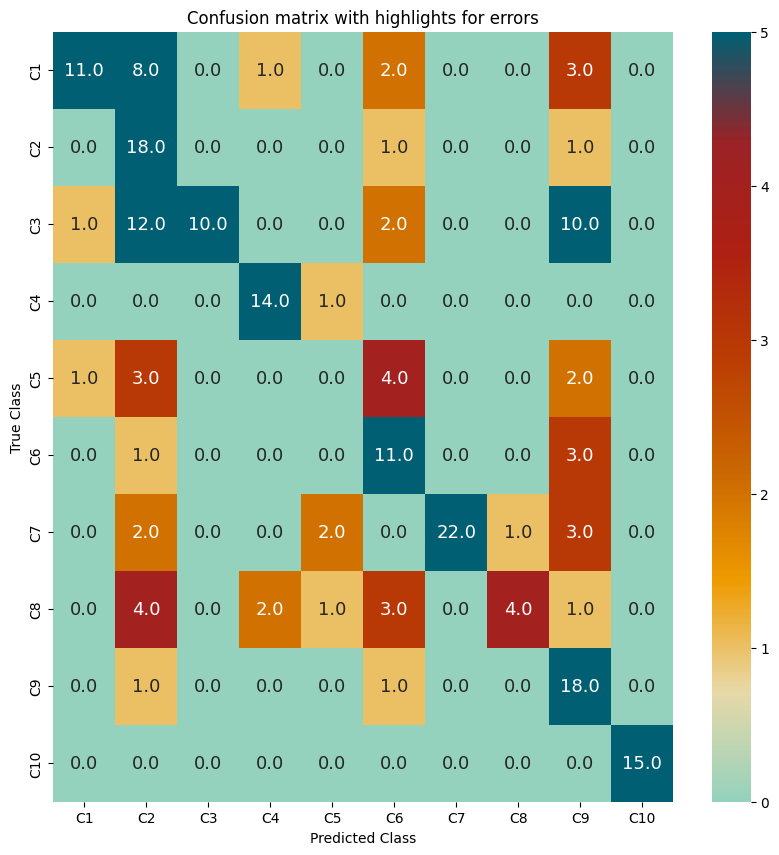

In [61]:
plt.figure(figsize=(10,10))
sn.heatmap(cf_matrix,
           annot=True,
           fmt="",
           annot_kws={"size": 13},
           xticklabels=CLASSES,
           yticklabels=CLASSES,
           cmap=cmap_error,
           vmin=0,
           vmax=5)

plt.title("Confusion matrix with highlights for errors")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

plt.show()